## Project FMST - Solution by Shiva Pingle

Objective : To predict the concrete strength using the data available in file "concrete.csv". 

Apply feature engineering and model tuning to obtain 85% to 95% accuracy.


    
The data for this project is available in file https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/. The same has been shared along with the course content.


In [1]:
# Import important libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor  
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import BaggingRegressor
from scipy.stats import randint as sp_randint


In [2]:
#Functions to be used later

def sanity_check_1(df):
    dtype = df.dtypes
    null = df.isnull().sum()
    unique = df.nunique()

    result_df = pd.concat([dtype, null, unique], axis=1)
    result_df.columns = ['dtype', 'null', 'unique']
    result_df['null_%'] = result_df['null'].values / len(df)
    print(df.info())
    result_df.sort_values(['unique'],inplace=True)
    
    return result_df


def univariate_numerical(df):
    univariate_df = pd.concat([df.describe(percentiles=[i/10 for i in range(1, 10)]).T, df.skew()], axis=1)
    univariate_df.rename(columns={0:"skew"}, inplace=True)
    return univariate_df


def chi_square(data, features, target):
    
    output = dict()
    
    for feature in features:

        data_crosstab = pd.crosstab(data[feature],  
                                    data[target], 
                                        margins = False)

        stat, p, dof, expected = chi2_contingency(data_crosstab)
        
        output[feature] = [stat, p]
    
    return output

def f_values(data, features, target):
    X = data[features].values
    y = data[target].values

    f_values, p_values = f_classif(X, y)
    result = {feature:[f_value, p_value] for feature, f_value, p_value in zip(features, f_values, p_values)}
    return result

In [7]:
df = pd.read_csv("Dummy_Data_-_Train.csv")
df_freq = pd.read_csv("frequency_domain_features_train.csv")
df_heart = pd.read_csv("heart_rate_non_linear_features_train.csv")
df_time = pd.read_csv("time_domain_features_train.csv")

s1 = sanity_check_1(df_freq)
s2 = sanity_check_1(df_heart)
s3 = sanity_check_1(df_time)
print("Frequence domain features",s1)
print("Heart rate non linear",s2)
print("Time domain features",s3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369289 entries, 0 to 369288
Data columns (total 12 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   uuid     369289 non-null  object 
 1   VLF      369289 non-null  float64
 2   VLF_PCT  369289 non-null  float64
 3   LF       369289 non-null  float64
 4   LF_PCT   369289 non-null  float64
 5   LF_NU    369289 non-null  float64
 6   HF       369289 non-null  float64
 7   HF_PCT   369289 non-null  float64
 8   HF_NU    369289 non-null  float64
 9   TP       369289 non-null  float64
 10  LF_HF    369289 non-null  float64
 11  HF_LF    369289 non-null  float64
dtypes: float64(11), object(1)
memory usage: 33.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369289 entries, 0 to 369288
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   uuid       369289 non-null  object 
 1   SD1        369289 non-null  float64
 2   SD2  

In [9]:
print("df_freq",df_freq.shape)
print("df_heart",df_heart.shape)
print("df_time",df_time.shape)

df_freq (369289, 12)
df_heart (369289, 7)
df_time (369289, 20)


In [15]:
df_merged1 = pd.merge(df_freq,df_heart,how='inner',on='uuid')
df_merged = pd.merge(df_merged1,df_time,how='inner',on='uuid')
print(df_merged1.shape)
print(df_merged.shape)

(369289, 18)
(369289, 37)


In [18]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369289 entries, 0 to 369288
Data columns (total 37 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   uuid               369289 non-null  object 
 1   VLF                369289 non-null  float64
 2   VLF_PCT            369289 non-null  float64
 3   LF                 369289 non-null  float64
 4   LF_PCT             369289 non-null  float64
 5   LF_NU              369289 non-null  float64
 6   HF                 369289 non-null  float64
 7   HF_PCT             369289 non-null  float64
 8   HF_NU              369289 non-null  float64
 9   TP                 369289 non-null  float64
 10  LF_HF              369289 non-null  float64
 11  HF_LF              369289 non-null  float64
 12  SD1                369289 non-null  float64
 13  SD2                369289 non-null  float64
 14  sampen             369289 non-null  float64
 15  higuci             369289 non-null  float64
 16  da

In [20]:
df_merged.nunique()

uuid                 369289
VLF                  369289
VLF_PCT              369289
LF                   369289
LF_PCT               369289
LF_NU                369289
HF                   369289
HF_PCT               369289
HF_NU                369289
TP                   369289
LF_HF                369289
HF_LF                369289
SD1                  369289
SD2                  369289
sampen                82511
higuci               369289
datasetId                 1
condition                 3
MEAN_RR              369289
MEDIAN_RR            106329
SDRR                 369289
RMSSD                369289
SDSD                 369289
SDRR_RMSSD           369289
HR                   369289
pNN25                   592
pNN50                    83
KURT                 369289
SKEW                 369289
MEAN_REL_RR          369289
MEDIAN_REL_RR         25041
SDRR_REL_RR          369289
RMSSD_REL_RR         369289
SDSD_REL_RR          369289
SDRR_RMSSD_REL_RR    369289
KURT_REL_RR         

In [22]:
df_merged.isnull().sum()

uuid                 0
VLF                  0
VLF_PCT              0
LF                   0
LF_PCT               0
LF_NU                0
HF                   0
HF_PCT               0
HF_NU                0
TP                   0
LF_HF                0
HF_LF                0
SD1                  0
SD2                  0
sampen               0
higuci               0
datasetId            0
condition            0
MEAN_RR              0
MEDIAN_RR            0
SDRR                 0
RMSSD                0
SDSD                 0
SDRR_RMSSD           0
HR                   0
pNN25                0
pNN50                0
KURT                 0
SKEW                 0
MEAN_REL_RR          0
MEDIAN_REL_RR        0
SDRR_REL_RR          0
RMSSD_REL_RR         0
SDSD_REL_RR          0
SDRR_RMSSD_REL_RR    0
KURT_REL_RR          0
SKEW_REL_RR          0
dtype: int64

In [26]:
df_merged[['datasetId','HR']].head()

,datasetId,HR
0,2,69.499952
1,2,64.363150
2,2,67.450066
3,2,68.809562
4,2,74.565728


In [ ]:
de_merged.loc[]

In [27]:
type(df_merged['datasetId'])

pandas.core.series.Series

In [30]:
type(df_merged['TP'])

pandas.core.series.Series

In [31]:
df_merged.drop(['uuid','datasetId'],inplace=True,axis=1)

In [32]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369289 entries, 0 to 369288
Data columns (total 35 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   VLF                369289 non-null  float64
 1   VLF_PCT            369289 non-null  float64
 2   LF                 369289 non-null  float64
 3   LF_PCT             369289 non-null  float64
 4   LF_NU              369289 non-null  float64
 5   HF                 369289 non-null  float64
 6   HF_PCT             369289 non-null  float64
 7   HF_NU              369289 non-null  float64
 8   TP                 369289 non-null  float64
 9   LF_HF              369289 non-null  float64
 10  HF_LF              369289 non-null  float64
 11  SD1                369289 non-null  float64
 12  SD2                369289 non-null  float64
 13  sampen             369289 non-null  float64
 14  higuci             369289 non-null  float64
 15  condition          369289 non-null  object 
 16  ME

In [33]:
df_merged['condition'].unique()

array(['no stress', 'interruption', 'time pressure'], dtype=object)

In [37]:
print(df_merged['condition'].unique())
oneHotCols=['condition']
df_merged_final=pd.get_dummies(df_merged,columns=oneHotCols)
#df_merged_final['condition'].head(10)

['no stress' 'interruption' 'time pressure']


In [38]:
df_merged_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369289 entries, 0 to 369288
Data columns (total 37 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   VLF                      369289 non-null  float64
 1   VLF_PCT                  369289 non-null  float64
 2   LF                       369289 non-null  float64
 3   LF_PCT                   369289 non-null  float64
 4   LF_NU                    369289 non-null  float64
 5   HF                       369289 non-null  float64
 6   HF_PCT                   369289 non-null  float64
 7   HF_NU                    369289 non-null  float64
 8   TP                       369289 non-null  float64
 9   LF_HF                    369289 non-null  float64
 10  HF_LF                    369289 non-null  float64
 11  SD1                      369289 non-null  float64
 12  SD2                      369289 non-null  float64
 13  sampen                   369289 non-null  float64
 14  higu

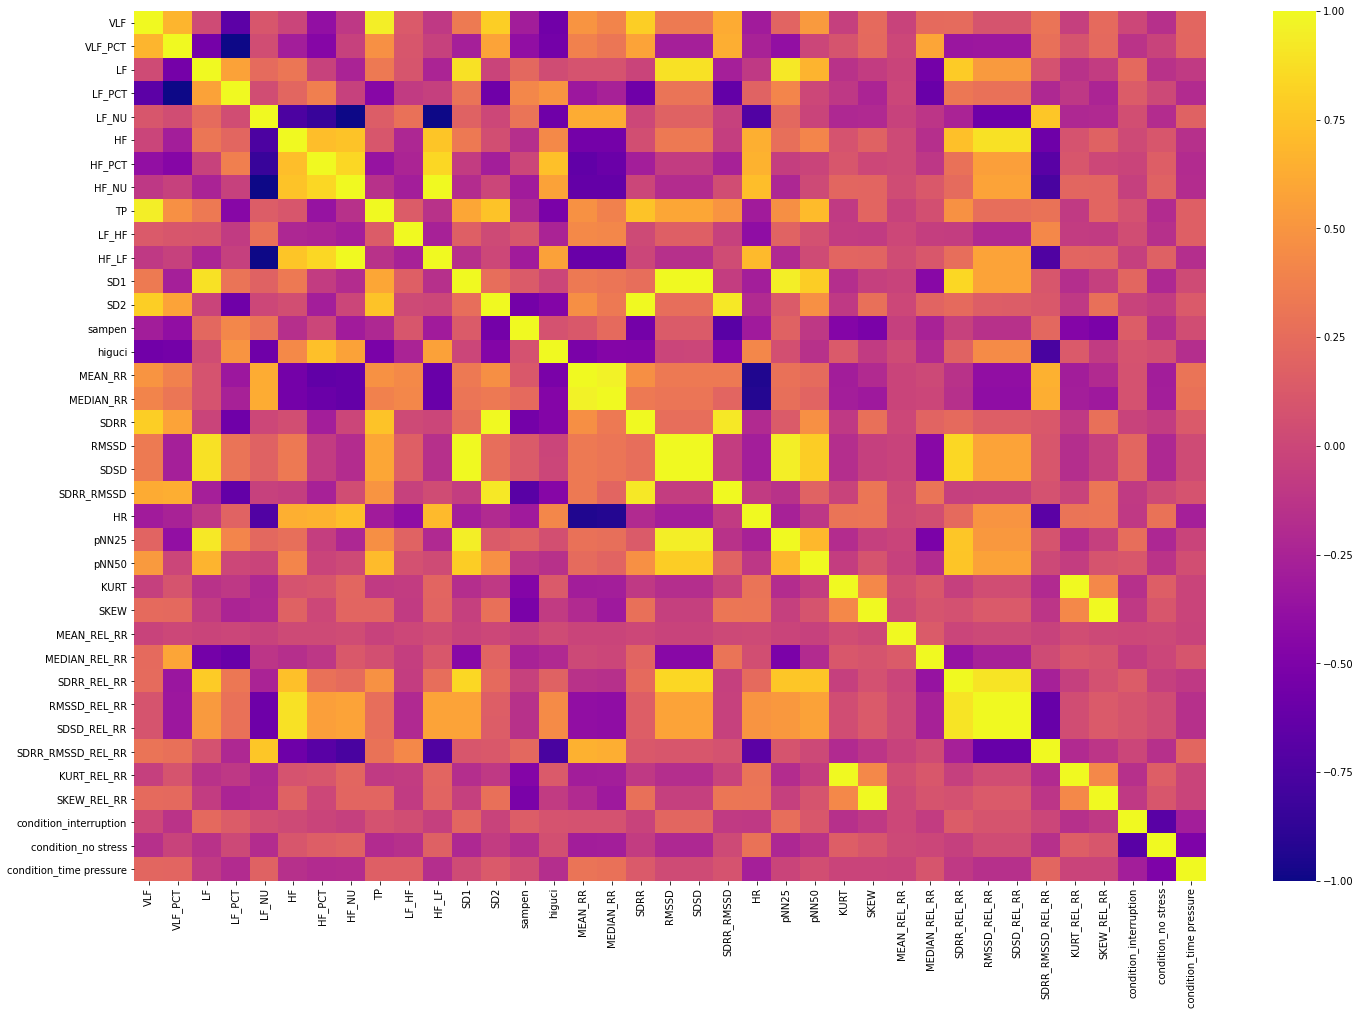

In [43]:
plt.figure(figsize=(24,16))  #setting the figure size
sns.heatmap(df_merged_final.corr(), cmap='plasma')  #heat map to plot the above table
plt.show()

In [42]:
corr = df_merged_final.corr()


                              VLF   VLF_PCT        LF    LF_PCT     LF_NU  \
VLF                      1.000000  0.676628  0.026521 -0.664830  0.105044   
VLF_PCT                  0.676628  1.000000 -0.541976 -0.995240  0.046868   
LF                       0.026521 -0.541976  1.000000  0.570404  0.247482   
LF_PCT                  -0.664830 -0.995240  0.570404  1.000000  0.043265   
LF_NU                    0.105044  0.046868  0.247482  0.043265  1.000000   
HF                      -0.010441 -0.283068  0.315662  0.216789 -0.749237   
HF_PCT                  -0.389684 -0.460465 -0.032871  0.371761 -0.840496   
HF_NU                   -0.105044 -0.046868 -0.247482 -0.043265 -1.000000   
TP                       0.951800  0.470337  0.331037 -0.452276  0.155373   
LF_HF                    0.126668  0.103768  0.099452 -0.082040  0.281325   
HF_LF                   -0.094013 -0.041519 -0.235807 -0.048411 -0.996175   
SD1                      0.341293 -0.278996  0.887012  0.299684  0.185263   

In [ ]:
#PCA
#Statistical model - pvalue


No Null values. 8 Quantitative, continuous features.

In [6]:
df_heart['condition'].unique()

array(['no stress', 'interruption', 'time pressure'], dtype=object)

In [10]:
all_cols = s1.index.tolist()
numeric_cols = s1.index.tolist()
print(numeric_cols)
numeric_cols.remove('strength')
print(numeric_cols)

['age', 'superplastic', 'ash', 'slag', 'water', 'cement', 'coarseagg', 'fineagg', 'strength']
['age', 'superplastic', 'ash', 'slag', 'water', 'cement', 'coarseagg', 'fineagg']


In [9]:
univariate_numerical(df_freq).T

,VLF,VLF_PCT,LF,LF_PCT,LF_NU,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF
count,369289.000000,369289.000000,369289.000000,369289.000000,369289.000000,369289.000000,369289.000000,369289.000000,369289.000000,369289.000000,369289.000000
mean,2199.580170,64.289242,946.530252,34.095182,95.566718,39.245603,1.615576,4.433282,3185.356025,115.977200,0.048506
std,1815.773422,16.774844,574.171780,16.040290,4.123365,45.398869,1.761073,4.123365,1923.227187,360.855129,0.049238
min,159.480176,19.031219,90.048557,2.165119,69.879083,0.061783,0.002150,0.012825,377.692795,2.319952,0.000128
10%,582.777829,39.623898,378.116790,14.555636,90.028011,4.035982,0.106436,0.426969,1177.188393,9.028090,0.004288
20%,889.389708,49.727192,491.796196,20.242485,92.839700,8.290088,0.237788,0.942945,1627.135386,12.965895,0.009519
30%,1116.353545,56.347931,590.899690,24.052643,94.322945,13.728314,0.475457,1.627213,2004.951842,16.614765,0.016541
40%,1382.686298,61.525754,679.898903,27.719833,95.622191,18.996860,0.751326,2.453468,2389.203201,21.842478,0.025152
50%,1667.903111,66.350237,782.716291,32.047025,96.643140,24.841938,1.039513,3.356860,2796.856587,28.789747,0.034735
60%,2002.098485,71.127727,903.361406,36.550968,97.546532,30.814847,1.398821,4.377809,3216.912877,39.758628,0.045782


In [10]:
univariate_numerical(df_heart).T

,SD1,SD2,sampen,higuci,datasetId
count,369289.000000,369289.000000,369289.000000,369289.000000,369289.0
mean,10.593708,154.178997,2.062471,1.182292,2.0
std,2.914795,109.170222,0.206999,0.062192,0.0
min,3.911344,38.307745,0.434576,1.033984,2.0
10%,6.829299,72.580917,1.836697,1.104629,2.0
20%,7.844358,85.925277,1.986132,1.133051,2.0
30%,8.719067,95.655395,2.062174,1.145568,2.0
40%,9.548666,104.819625,2.105447,1.159688,2.0
50%,10.196621,116.221063,2.134214,1.174293,2.0
60%,11.080329,132.883713,2.158299,1.191411,2.0


In [12]:
univariate_numerical(df_time).T

,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,KURT,SKEW,MEAN_REL_RR,MEDIAN_REL_RR,SDRR_REL_RR,RMSSD_REL_RR,SDSD_REL_RR,SDRR_RMSSD_REL_RR,KURT_REL_RR,SKEW_REL_RR
count,369289.000000,369289.000000,369289.000000,369289.000000,369289.000000,369289.000000,369289.000000,369289.000000,369289.000000,369289.000000,369289.000000,3.692890e+05,369289.000000,369289.000000,369289.000000,369289.000000,369289.000000,369289.000000,369289.000000
mean,846.650104,841.965890,109.352531,14.977498,14.976767,7.396597,73.941824,9.841143,0.866001,0.523235,0.041628,-1.756587e-06,-0.000465,0.018571,0.009701,0.009701,2.006817,0.523235,0.041628
std,124.603984,132.321005,77.117025,4.120766,4.120768,5.143834,10.337453,8.195574,0.990189,1.790348,0.699522,1.630256e-04,0.000868,0.005455,0.003897,0.003897,0.375845,1.790348,0.699522
min,547.492221,517.293295,27.233947,5.529742,5.529630,2.660381,48.737243,0.000000,0.000000,-1.894820,-2.136278,-1.233914e-03,-0.004425,0.008987,0.003220,0.003220,1.169342,-1.894820,-2.136278
10%,714.175996,705.875640,51.638541,9.655358,9.654865,3.735125,60.752960,1.533333,0.000000,-0.673194,-0.677715,-1.663766e-04,-0.001619,0.012814,0.005829,0.005829,1.580814,-0.673194,-0.677715
20%,743.381110,736.350515,61.109937,11.090066,11.089896,4.319697,64.805449,2.800000,0.000000,-0.433137,-0.442126,-9.435094e-05,-0.001079,0.013840,0.006626,0.006626,1.700450,-0.433137,-0.442126
30%,773.938351,769.343375,68.063954,12.327203,12.326510,4.847109,68.192070,4.400000,0.133333,-0.278083,-0.291182,-5.548862e-05,-0.000773,0.014864,0.007311,0.007311,1.794292,-0.278083,-0.291182
40%,797.803667,792.881317,74.569676,13.500059,13.499348,5.414812,71.067804,6.066667,0.266667,-0.127697,-0.164023,-2.649771e-05,-0.000518,0.016123,0.007882,0.007882,1.865068,-0.127697,-0.164023
50%,822.951438,819.689595,82.608243,14.415918,14.415388,5.952112,74.217809,7.600000,0.466667,0.040736,-0.060966,-9.330777e-07,-0.000312,0.017318,0.008691,0.008691,1.934416,0.040736,-0.060966
60%,860.330541,853.365970,94.330288,15.665773,15.664724,6.534621,76.400485,9.400000,0.733333,0.258665,0.057536,2.429605e-05,-0.000123,0.018855,0.009402,0.009402,2.036133,0.258665,0.057536


<AxesSubplot:xlabel='HR', ylabel='Density'>

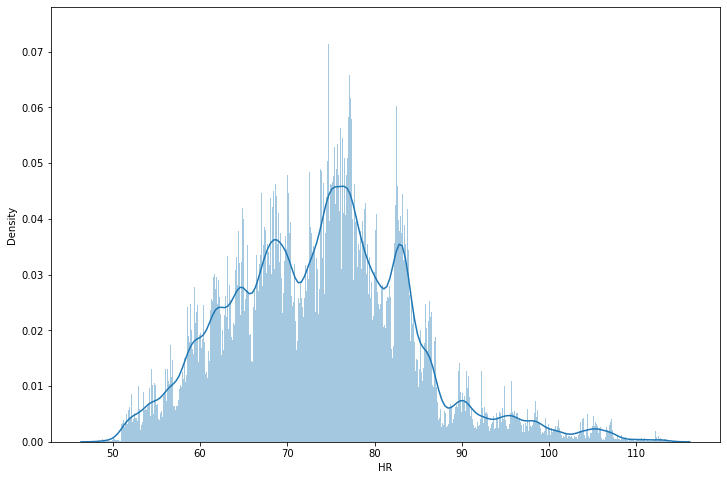

In [4]:
plt.figure(figsize=(12,8))
sns.distplot(df_time['HR'],bins=2000)

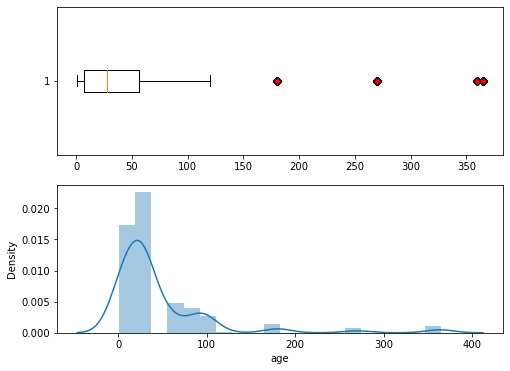

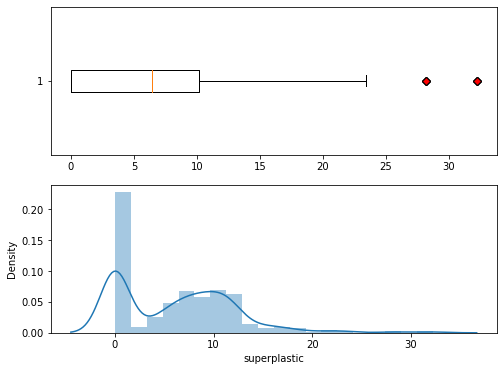

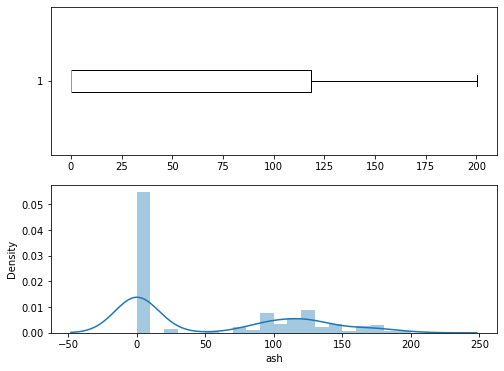

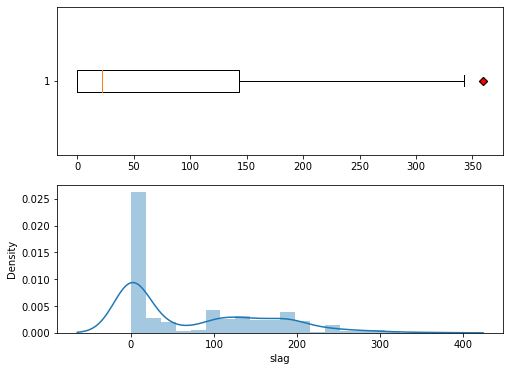

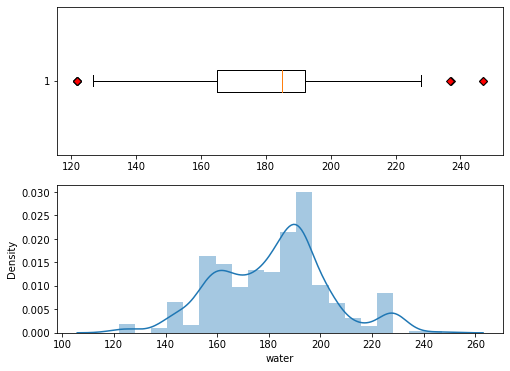

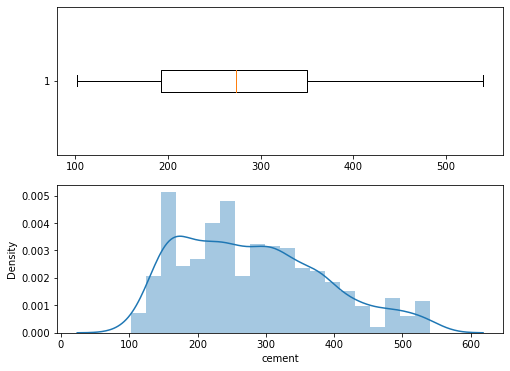

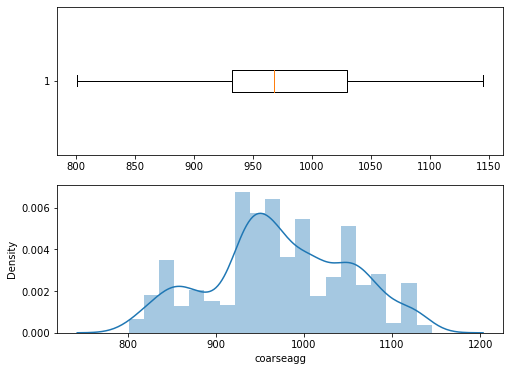

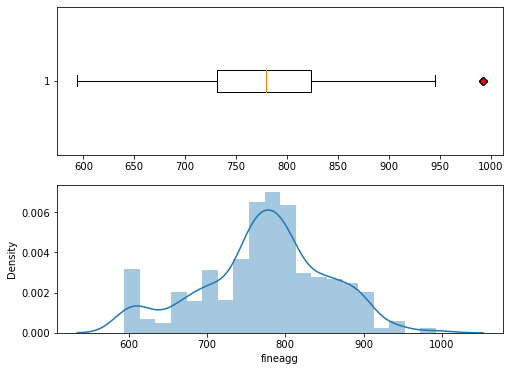

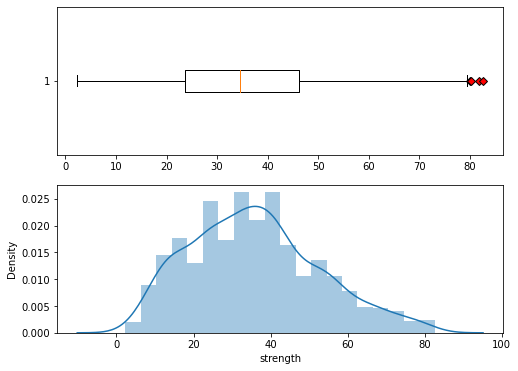

In [12]:
for i in all_cols:
    fig, axes = plt.subplots(2,1,figsize=(8,6))
    axes[0].boxplot(df[i],flierprops=dict(markerfacecolor='r',marker='D'),vert=False)
    sns.distplot(df[i],bins=20)

Conclusion from Boxplots - 'age', 'superplastic' features and 'strength' output variable have outliers on the higher side.


* Cement is normally distributed. 
* Slag has three gausssians and rightly skewed. 
* Ash has two gaussians and rightly skewed. 
* Water has three guassians and slighly left skewed. 
* Superplastic has two gaussians and rightly skewed. 
* Coarseagg has three guassians and almost normal. 
* Fineagg has almost two guassians and looks like normal. 
* Age has multiple guassians and rightly skewed.

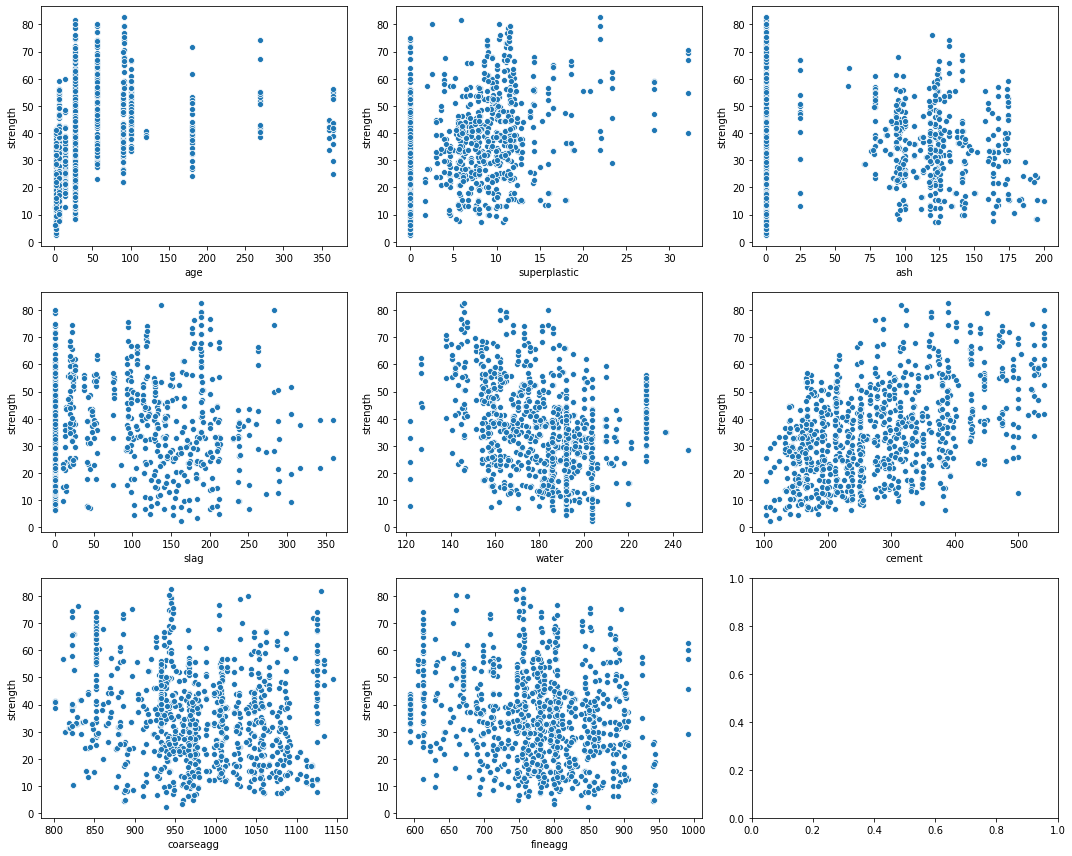

In [7]:

fig, axes = plt.subplots(3,3, figsize=(15,12))

for i,feat in enumerate(numeric_cols):
    sns.scatterplot(x=feat,y='strength',data=df,ax=axes.flatten()[i])
plt.tight_layout()



Relationship between independent columns * 

* Except the cement column no other columns have found to have a visible linear relationship with the strength column. 

* The columns coarseagg and fineagg seems to have slight positive linear relationship.
The presence of outliers are seen between columns slag and ash and as well as cement and ash 
* The presence of outliers are seen between columns fineagg and ash and as well as coarseagg and ash  
* The presence of outliers are seen between columns water and ash 
The presence of outliers are seen between column superplastic and the columns cement, slag, coarseagg, and fineagg * 
* It is clearly seen that most of the columns do not have any linear relationship between them. Relationship between target and independent columns * 
There seems to be a linear relationship between cement and strength column 
* There are outliers found between cement and ash columns 
Relationship between Independent attributes/variables:-
* Majority of the independent attributes does not have any significant relationship with other independent attributes. "superplastic" and "water" display negative/inverse relationship. "fineagg" and "water" display negative/inverse relationship. Relationship between Independent attributes and dependent/target variable "strength" vs "cement": It is linearly related to the cement. The relationship is positive. This could be good predictor "strength" vs "superplastic": Some amount of positive trend / relationship. "strength vs other attributes: 
*None of the other attributes display any significant relationship with strength variable.



Age feature has only 14 unique values. The pie chart of those values is shown here.


<AxesSubplot:ylabel='age'>

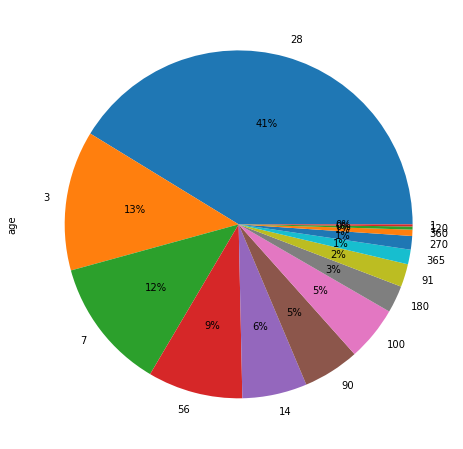

In [8]:
print("Age feature has only {} unique values. The pie chart of those values is shown here.".format(df['age'].nunique()))
plt.figure(figsize=(8,8))
df['age'].value_counts().plot(kind='pie',autopct='%1.0f%%') # Pie chart representation of different Races of people.

<AxesSubplot:>

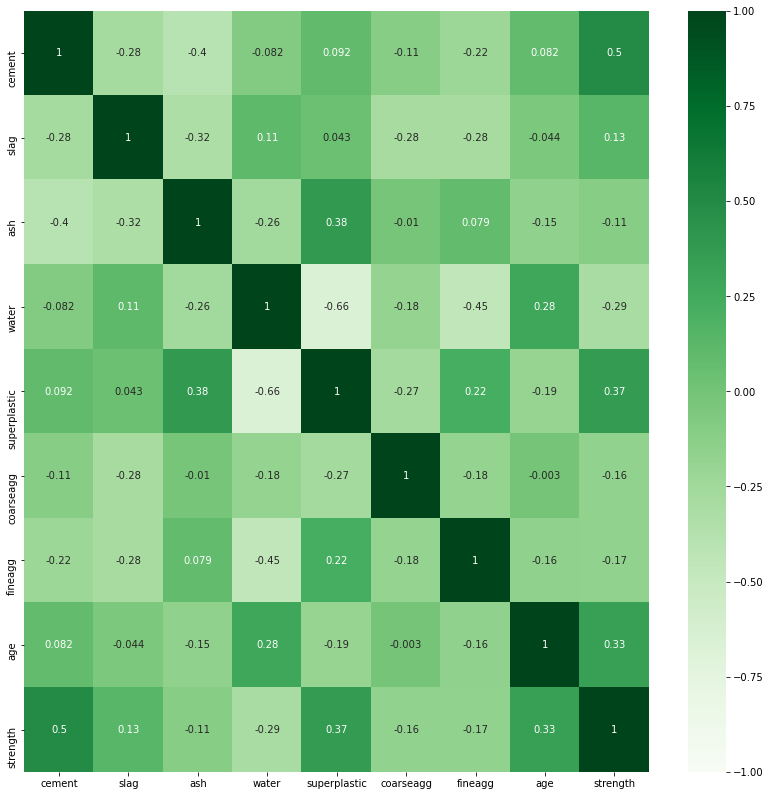

In [9]:
plt.figure(figsize=(14,14))
sns.heatmap(df.corr(),vmin=-1,vmax=1,annot=True,cmap="Greens") # It will show correlation matrix 

'age' and 'superplastic' and 'cement' are weakly correlated to the target variable 'strength'. 

# Linear Regression, Ridge and Lasso Algorithms with Polynomial Features

In [10]:
X = df[numeric_cols]
y = df[['strength']]
resultsDf = []

In [11]:
poly = PolynomialFeatures(3, include_bias=False)
X_poly = poly.fit_transform(X)
print(X_poly.shape)

(1030, 164)


In [12]:
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.25,random_state=42)

In [13]:
ln_regression = LinearRegression()
ln_regression.fit(X_train_poly, y_train)

y_pred_reg1 = ln_regression.predict(X_test_poly) 

score1 = ln_regression.score(X_train_poly, y_train)
nrmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_reg1)) / np.mean(y_test)

print('Linear Regression')
print()
print('R^2 Coefficient for Train data: %.4f'% score1)
print('R^2 Coefficient for Test data: %.4f'% r2_score(y_test, y_pred_reg1))

resultsDf = pd.DataFrame({'Method':['Linear Regression'],'PolynomialFeatures(Y/N)':['Yes'], 'R2 Score Training': score1, 'R2 Score Test': r2_score(y_test, y_pred_reg1),'NRMSE':nrmse_lr})
resultsDf = resultsDf[['Method','PolynomialFeatures(Y/N)', 'R2 Score Training','R2 Score Test','NRMSE']]

Linear Regression

R^2 Coefficient for Train data: 0.9344
R^2 Coefficient for Test data: 0.8354


In [14]:
ridge = Ridge(alpha=0.0100)
ridge.fit(X_train_poly,y_train)
y_pred_reg_Ridge = ridge.predict(X_test_poly) 
score3 = ridge.score(X_train_poly,y_train)
nrmse_Ridge = np.sqrt(mean_squared_error(y_test, y_pred_reg_Ridge)) / np.mean(y_test)
print('Ridge Regression')
print()

print('Ridge Regression: R^2 Coefficient for Train data: %.4f'% score3)
print('Ridge Regression: R^2 Coefficient for Test data: %.4f'% r2_score(y_test, y_pred_reg_Ridge))

tempResultsDf = pd.DataFrame({'Method':['Ridge Regression'],'PolynomialFeatures(Y/N)':['Yes'] ,'R2 Score Training': score3, 'R2 Score Test': r2_score(y_test, y_pred_reg_Ridge),'NRMSE':nrmse_Ridge})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method','PolynomialFeatures(Y/N)', 'R2 Score Training','R2 Score Test','NRMSE']]

Ridge Regression

Ridge Regression: R^2 Coefficient for Train data: 0.9330
Ridge Regression: R^2 Coefficient for Test data: 0.8442


In [15]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_poly,y_train)
y_pred_reg_Lasso = lasso.predict(X_test_poly)
score4 = lasso.score(X_train_poly,y_train)
nrmse_Lasso = np.sqrt(mean_squared_error(y_test, y_pred_reg_Lasso)) / np.mean(y_test)
print('Lasso Regression')
print()
print('Lasso Regression: R^2 Coefficient for Train data: %.4f'% score4)
print('Lasso Regression: R^2 Coefficient for Test data: %.4f'% r2_score(y_test, y_pred_reg_Lasso))


tempResultsDf = pd.DataFrame({'Method':['Lasso Regression'],'PolynomialFeatures(Y/N)':['Yes'] ,'R2 Score Training': score4, 'R2 Score Test': r2_score(y_test, y_pred_reg_Lasso),'NRMSE':nrmse_Lasso})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method','PolynomialFeatures(Y/N)', 'R2 Score Training','R2 Score Test','NRMSE']]

Lasso Regression

Lasso Regression: R^2 Coefficient for Train data: 0.8970
Lasso Regression: R^2 Coefficient for Test data: 0.8190


# Decision Tree Regressor

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

R^2 of the prediction - Training Data: 0.995
R^2 of the prediction - Testing Data 0.883


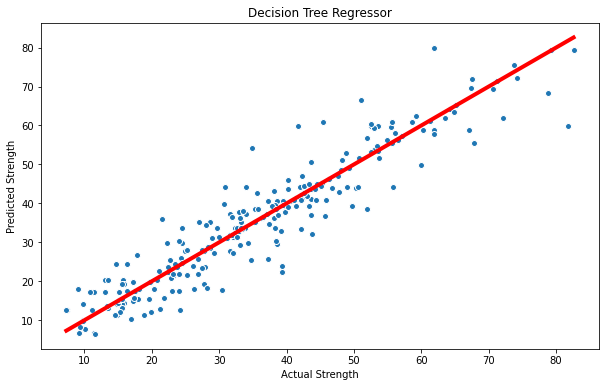

In [17]:
# create a regressor object 
DT_regressor = DecisionTreeRegressor()
DT_regressor.fit(X_train, y_train) 
y_pred = DT_regressor.predict(X_test) 
score1 = DT_regressor.score(X_train, y_train)
nrmse_DT = np.sqrt(mean_squared_error(y_test, y_pred)) / np.mean(y_test)
print('R^2 of the prediction - Training Data: %.3f'%score1)
print('R^2 of the prediction - Testing Data %.3f'% r2_score(y_test, y_pred))
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_test, y_pred, edgecolors=(1,1,1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', lw=4)
ax.set_xlabel('Actual Strength')
ax.set_ylabel('Predicted Strength')
ax.set_title("Decision Tree Regressor")
plt.show()
#print(DT_regressor.get_params)


tempResultsDf = pd.DataFrame({'Method':['Decision Tree Regressor'],'PolynomialFeatures(Y/N)':['No'] ,'R2 Score Training': score1, 'R2 Score Test': r2_score(y_test, y_pred),'NRMSE':nrmse_DT})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method','PolynomialFeatures(Y/N)', 'R2 Score Training','R2 Score Test','NRMSE']]

The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.


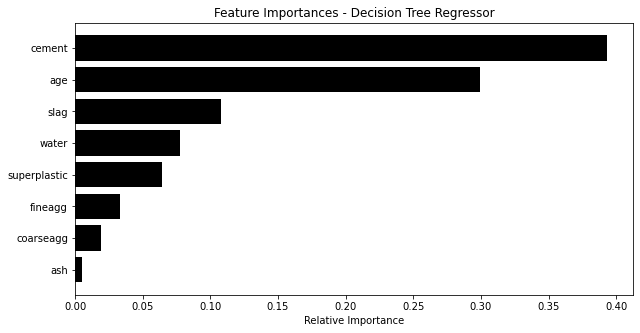

In [18]:
importances = DT_regressor.feature_importances_
indices = np.argsort(importances)
features = X.columns
print("The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.")
plt.figure(figsize=(10,5))
plt.title('Feature Importances - Decision Tree Regressor')
plt.barh(range(len(indices)), importances[indices], color='k', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

# Gradient Boost Regressor

Boosting Regressor Model
R^2 score on training data: 0.9488107035452578
R^2 score on test data: 0.8954272146156117
Normalised mean sqared error: strength    0.150207
dtype: float64


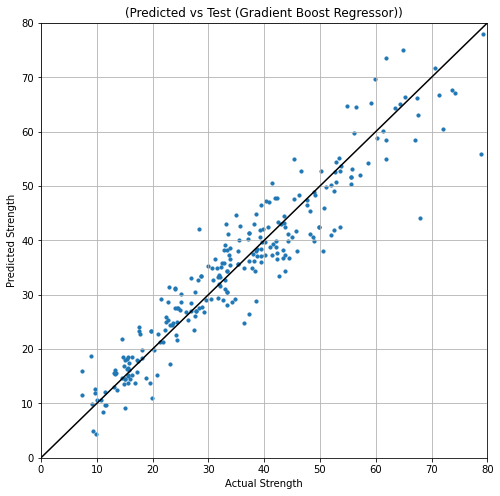

In [19]:
#params_GBR = {'loss': 'ls','learning_rate': 0.03,'n_estimators': 200,'subsample': 0.8,'max_depth': 64,
#              'max_features': 0.3,'min_impurity_decrease': 1e-10,'min_samples_leaf': 5}
print('Boosting Regressor Model')

reg_gbr = GradientBoostingRegressor(random_state=98)
reg_gbr.fit(X_train, y_train)
y_pred_GBR = reg_gbr.predict(X_test)
nrmse_GBR = np.sqrt(mean_squared_error(y_test, y_pred_GBR)) / np.mean(y_test)
score5 = reg_gbr.score(X_train, y_train)
print("R^2 score on training data: {}".format(reg_gbr.score(X_train,y_train)))
print("R^2 score on test data: {}".format(reg_gbr.score(X_test,y_test)))
print("Normalised mean sqared error: {}".format(nrmse_GBR))

plt.figure(figsize=(8,8))
plt.plot(np.linspace(0,100,10),np.linspace(0,100,10),'-k')
plt.scatter(y_test, y_pred_GBR, s=10)
plt.xlabel('Actual Strength');plt.ylabel('Predicted Strength'),plt.title('(Predicted vs Test (Gradient Boost Regressor))')
plt.grid();plt.xlim(0,80);plt.ylim(0,80)
#print(reg_gbr.get_params())



tempResultsDf = pd.DataFrame({'Method':['Gradient Boost Regressor'],'PolynomialFeatures(Y/N)':['No'],'R2 Score Training': score5, 'R2 Score Test': r2_score(y_test, y_pred_GBR),'NRMSE':nrmse_GBR})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method','PolynomialFeatures(Y/N)', 'R2 Score Training','R2 Score Test','NRMSE']]

Bagging Regressor Model
R^2 score on training data: 0.9747377866558595
R^2 score on test data: 0.906813458738895
Normalised mean squared error: strength    0.141794
dtype: float64


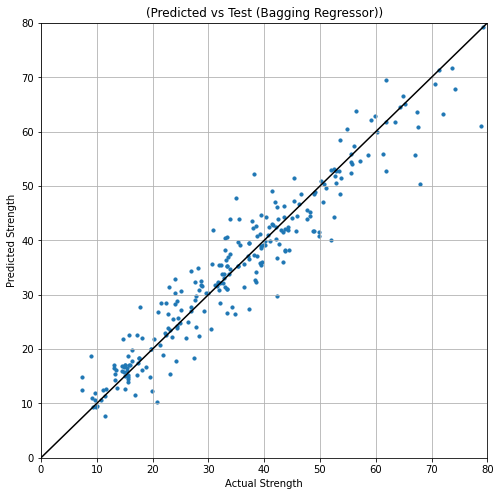

In [20]:
print('Bagging Regressor Model')
reg_bgr = BaggingRegressor(random_state=98)
reg_bgr.fit(X_train, y_train)
y_pred_BGR = reg_bgr.predict(X_test)
score6 = reg_bgr.score(X_train, y_train)
nrmse_BGR = np.sqrt(mean_squared_error(y_test, y_pred_BGR)) / np.mean(y_test)
print("R^2 score on training data: {}".format(reg_bgr.score(X_train,y_train)))
print("R^2 score on test data: {}".format(reg_bgr.score(X_test,y_test)))
print("Normalised mean squared error: {}".format(nrmse_BGR))

plt.figure(figsize=(8,8))
plt.plot(np.linspace(0,200,10),np.linspace(0,200,10),'-k')
plt.scatter(y_test, y_pred_BGR, s=10)
plt.xlabel('Actual Strength');plt.ylabel('Predicted Strength'),plt.title('(Predicted vs Test (Bagging Regressor))')
plt.grid();plt.xlim(0,80);plt.ylim(0,80)
#print(reg_bgr.get_params())

tempResultsDf = pd.DataFrame({'Method':['Bagging Regressor'],'PolynomialFeatures(Y/N)':['No'],'R2 Score Training': score6, 'R2 Score Test': r2_score(y_test, y_pred_BGR),'NRMSE':nrmse_BGR})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method','PolynomialFeatures(Y/N)', 'R2 Score Training','R2 Score Test','NRMSE']]

In [21]:
resultsDf.reset_index(inplace=True)
resultsDf.drop(['index'], axis=1,inplace=True)
resultsDf = resultsDf.round(3)
resultsDf

,Method,PolynomialFeatures(Y/N),R2 Score Training,R2 Score Test,NRMSE
0,Linear Regression,Yes,0.934,0.835,0.188
1,Ridge Regression,Yes,0.933,0.844,0.183
2,Lasso Regression,Yes,0.897,0.819,0.198
3,Decision Tree Regressor,No,0.995,0.883,0.159
4,Gradient Boost Regressor,No,0.949,0.895,0.150
5,Bagging Regressor,No,0.975,0.907,0.142


Performance metrics for 3 linear regression methods and 3 Decision tree based regression methods are reported in this table. NRMSE - Normalised root mean square error (RMSE normalised by mean of Y_Test). Polynomial Features are used for Linar regresison, Ridge and Lasso regression only. Raw features are input in the decision tree based regressors.

# Cross-Validation

In [22]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
resultsDf_CV = []

num_folds = 20
seed = 7
print("Cross-validation for Linear Regression")
kfold = KFold(n_splits = num_folds,random_state=7)
ln_regression = LinearRegression()
res_CV_ln_regression = cross_val_score(ln_regression,X,y,cv=kfold)

R2_Score_LR_CV = res_CV_ln_regression.mean()
stddev_LR_CV = res_CV_ln_regression.std()

resultsDf_CV = pd.DataFrame({'Method':['Linear Regression'],'R2 Score after CV': R2_Score_LR_CV.round(3), 'Standard Dev': stddev_LR_CV.round(3)})
resultsDf_CV = resultsDf_CV[['Method','R2 Score after CV', 'Standard Dev']]

Cross-validation for Linear Regression


In [23]:
print("Cross-validation for Decision Tree Regressor")
kfold = KFold(n_splits = num_folds,random_state=7)

DT_regressor = DecisionTreeRegressor()

res_CV_DT = cross_val_score(DT_regressor,X,y,cv=kfold)


R2_Score_DT = res_CV_DT.mean()
stddev_DT = res_CV_DT.std()

tempResultsDf_CV = pd.DataFrame({'Method':['Decision Tree Regressor'],'R2 Score after CV': R2_Score_DT.round(3), 'Standard Dev': stddev_DT.round(3)})
resultsDf_CV = pd.concat([resultsDf_CV, tempResultsDf_CV])
resultsDf_CV = resultsDf_CV[['Method','R2 Score after CV', 'Standard Dev']]


Cross-validation for Decision Tree Regressor


In [24]:
print("Cross-validation for Bagging Regressor")
kfold = KFold(n_splits = num_folds,random_state=7)

reg_bgr = BaggingRegressor(random_state=98)

res_CV_bgr = cross_val_score(reg_bgr,X,y,cv=kfold)


R2_Score_bgr = res_CV_bgr.mean()
stddev_bgr = res_CV_bgr.std()

tempResultsDf_CV = pd.DataFrame({'Method':['Bagging Regressor'],'R2 Score after CV': R2_Score_bgr.round(3), 'Standard Dev': stddev_bgr.round(3)})
resultsDf_CV = pd.concat([resultsDf_CV, tempResultsDf_CV])
resultsDf_CV = resultsDf_CV[['Method','R2 Score after CV', 'Standard Dev']]


Cross-validation for Bagging Regressor


In [25]:
print("Cross-validation for Gradient Boost Regressor")
kfold = KFold(n_splits = num_folds,random_state=7)

reg_gbr = GradientBoostingRegressor(random_state=98)

res_CV_gbr = cross_val_score(reg_gbr,X,y,cv=kfold)


R2_Score_gbr = res_CV_gbr.mean()
stddev_gbr = res_CV_gbr.std()


tempResultsDf_CV = pd.DataFrame({'Method':['Gradient Boost Regressor'],'R2 Score after CV': R2_Score_gbr.round(3), 'Standard Dev': stddev_gbr.round(3)})
resultsDf_CV = pd.concat([resultsDf_CV, tempResultsDf_CV])
resultsDf_CV = resultsDf_CV[['Method','R2 Score after CV', 'Standard Dev']]


Cross-validation for Gradient Boost Regressor


In [26]:
resultsDf_CV.reset_index(inplace=True)
resultsDf_CV.drop(['index'], axis=1,inplace=True)
print("This table is obtained by Cross-validation for Bagging Regressor")
resultsDf_CV

This table is obtained by Cross-validation for Bagging Regressor


,Method,R2 Score after CV,Standard Dev
0,Linear Regression,0.590,0.097
1,Decision Tree Regressor,0.869,0.058
2,Bagging Regressor,0.912,0.031
3,Gradient Boost Regressor,0.906,0.026


Cross-Validation  - The R2 score is the mean of the array containing cross validation scores. The R2 score and standard deviation are derived from the cross validation score array and reported. The score deteriorates with increasing "num_folds" value.

# Using  RandomizedSearchCV() for finding optimum parameteres

In [27]:
print("Find out the best parameters for the Gradient Boost Regressor.")
GBR_dict = {'learning_rate': np.arange(0.1,0.3,0.05),
          'n_estimators': np.arange(10,300,50),
          'subsample': [0.5,1],
          'max_depth': np.arange(2,10,2),
          'max_features': np.arange(0.25,1,0.25),
          'min_impurity_decrease': [0,0.1,1e-10,1e-20],
          'min_samples_leaf': np.arange(5,25,5)
             }
tic = time.time()
reg_gbr = GradientBoostingRegressor()
gbr_RandomCV = RandomizedSearchCV(reg_gbr, param_distributions=GBR_dict,cv=15,n_iter=150,n_jobs=2)
gbr_RandomCV.fit(X, y)
toc = time.time()

print('Best Test Score:',gbr_RandomCV.best_score_.round(2))
print("Time taken in seconds:",(toc-tic))


best_params_GBR = gbr_RandomCV.best_params_
print('Best parameters:',best_params_GBR)


print('Boosting Regressor Model with Best parameters obtained from RandomizedSearchCV')
print()
print()
reg_gbr1 = GradientBoostingRegressor(random_state=98,**best_params_GBR)
reg_gbr1.fit(X_train, y_train)
y_pred_GBR = reg_gbr1.predict(X_test)
nrmse_GBR1 = np.sqrt(mean_squared_error(y_test, y_pred_GBR)) / np.mean(y_test)
score_GBR_CV = reg_gbr1.score(X_train, y_train)
print("R^2 score on training data: {}".format(reg_gbr1.score(X_train,y_train)))
print("R^2 score on test data: {}".format(reg_gbr1.score(X_test,y_test)))
print("Normalised mean sqared error: {}".format(nrmse_GBR1))


tempResultsDf = pd.DataFrame({'Method':['Gradient Boost Regressor (RandomizedSearchCV)'],'PolynomialFeatures(Y/N)':['No'],'R2 Score Training': score_GBR_CV, 'R2 Score Test': r2_score(y_test, y_pred_BGR),'NRMSE':nrmse_GBR1})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method','PolynomialFeatures(Y/N)', 'R2 Score Training','R2 Score Test','NRMSE']]


Find out the best parameters for the Gradient Boost Regressor.
Best Test Score: 0.95
Time taken in seconds: 146.96472930908203
Best parameters: {'subsample': 0.5, 'n_estimators': 260, 'min_samples_leaf': 5, 'min_impurity_decrease': 1e-20, 'max_features': 0.25, 'max_depth': 8, 'learning_rate': 0.1}
Boosting Regressor Model with Best parameters obtained from RandomizedSearchCV


R^2 score on training data: 0.9907657904878101
R^2 score on test data: 0.9266801185465631
Normalised mean sqared error: strength    0.125774
dtype: float64


In [28]:
print("Find out the best parameters for the Decision Tree Regressor Regressor.")

from scipy.stats import randint as sp_randint

DT_dict = {"max_depth": np.arange(100,300,1),
              "min_samples_split": sp_randint(1,10),
              "min_samples_leaf": sp_randint(1,10),
              'criterion':['mse','mae'],
             'min_weight_fraction_leaf':[0.001,0.0015,0.0016,0.002,0.0021,0.01],           
            }
tic = time.time()
DT_regressor = DecisionTreeRegressor()
DT_RandomCV = RandomizedSearchCV(DT_regressor, param_distributions=DT_dict,cv=10,n_iter=50,n_jobs=2)
DT_RandomCV.fit(X, y)
toc = time.time()
print('Best Test Score:',DT_RandomCV.best_score_.round(2))
print("Time taken in seconds:",(toc-tic))
DT_params = DT_RandomCV.best_params_
print("Best Parameters are:\n",DT_params)
print()
print()

DT_regressor1 = DecisionTreeRegressor(**DT_params)
# fit the regressor with X and Y data 
DT_regressor1.fit(X_train, y_train) 
y_pred = DT_regressor1.predict(X_test) 
score_DT_CV = DT_regressor1.score(X_train, y_train)
nrmse_DT = np.sqrt(mean_squared_error(y_test, y_pred)) / np.mean(y_test)
# Explained variance score: 1 is perfect prediction
print('R^2 of the prediction - Training Data: %.3f'%score1)
# Explained variance score: 1 is perfect prediction
print('R^2 of the prediction - Testing Data %.3f'% r2_score(y_test, y_pred))
print()
tempResultsDf = pd.DataFrame({'Method':['Decision Tree Regressor (RandomizedSearchCV)'],'PolynomialFeatures(Y/N)':['No'],'R2 Score Training': score_DT_CV, 'R2 Score Test': r2_score(y_test, y_pred),'NRMSE':nrmse_DT})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method','PolynomialFeatures(Y/N)', 'R2 Score Training','R2 Score Test','NRMSE']]

Find out the best parameters for the Decision Tree Regressor Regressor.
Best Test Score: 0.87
Time taken in seconds: 5.5454816818237305
Best Parameters are:
 {'criterion': 'mse', 'max_depth': 134, 'min_samples_leaf': 2, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0015}


R^2 of the prediction - Training Data: 0.995
R^2 of the prediction - Testing Data 0.887



In [29]:
resultsDf.reset_index(inplace=True)
resultsDf.drop(['index'], axis=1,inplace=True)
resultsDf = resultsDf.round(3)
resultsDf

,Method,PolynomialFeatures(Y/N),R2 Score Training,R2 Score Test,NRMSE
0,Linear Regression,Yes,0.934,0.835,0.188
1,Ridge Regression,Yes,0.933,0.844,0.183
2,Lasso Regression,Yes,0.897,0.819,0.198
3,Decision Tree Regressor,No,0.995,0.883,0.159
4,Gradient Boost Regressor,No,0.949,0.895,0.150
5,Bagging Regressor,No,0.975,0.907,0.142
6,Gradient Boost Regressor (RandomizedSearchCV),No,0.991,0.907,0.126
7,Decision Tree Regressor (RandomizedSearchCV),No,0.980,0.887,0.156


The best hyper-parameters are obtained using RandomizedSearchCV. These parameters are input in the alogorithms. 
The R2 score and NRMSE improve (albeit slightly) due to usage of these "best parameters".